# MHD tests

## Imports

In [8]:
# %pip install ../

import os

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # second gpu

# numerics
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

# timing
from timeit import default_timer as timer

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# fluids
from jf1uids import SimulationConfig
from jf1uids import get_helper_data
from jf1uids import SimulationParams
from jf1uids import time_integration
from jf1uids.fluid_equations.fluid import construct_primitive_state2D

from jf1uids import get_registered_variables


## Initiatization

In [9]:
from jf1uids.option_classes.simulation_config import BACKWARDS, FORWARDS, HLL, HLLC, MINMOD, OSHER, PERIODIC_BOUNDARY, BoundarySettings, BoundarySettings1D

print("👷 Setting up simulation...")

# simulation settings
gamma = 5/3

# spatial domain
box_size = 1.0
num_cells = 512

fixed_timestep = False
scale_time = False
dt_max = 0.1
num_timesteps = 10

# setup simulation config
config = SimulationConfig(
    runtime_debugging = False,
    progress_bar = True,
    first_order_fallback = False,
    mhd = True,
    dimensionality = 2,
    box_size = box_size, 
    num_cells = num_cells,
    fixed_timestep = fixed_timestep,
    differentiation_mode = FORWARDS,
    num_timesteps = num_timesteps,
    limiter = MINMOD,
    riemann_solver = HLL,
    boundary_settings = BoundarySettings(BoundarySettings1D(left_boundary = PERIODIC_BOUNDARY, right_boundary = PERIODIC_BOUNDARY), BoundarySettings1D(left_boundary = PERIODIC_BOUNDARY, right_boundary = PERIODIC_BOUNDARY), BoundarySettings1D(left_boundary = PERIODIC_BOUNDARY, right_boundary = PERIODIC_BOUNDARY))
)

helper_data = get_helper_data(config)

params = SimulationParams(
    t_end = 0.5,
    C_cfl = 0.4
)

registered_variables = get_registered_variables(config)

👷 Setting up simulation...


## Setting the initial state

In [10]:
from jax.random import PRNGKey, uniform

from jf1uids.fluid_equations.fluid import construct_primitive_state2D_mhd

# Set the random seed for reproducibility
key = PRNGKey(0)

# Grid size and configuration
num_cells = config.num_cells
x = jnp.linspace(0, box_size, num_cells)
y = jnp.linspace(0, box_size, num_cells)
X, Y = jnp.meshgrid(x, y, indexing="ij")

# Initialize state
rho = jnp.ones_like(X) * 25 / (36 * jnp.pi)
P = jnp.ones_like(X) * 5 / (12 * jnp.pi)

V_x = -jnp.sin(2 * jnp.pi * Y)
V_y = jnp.sin(2 * jnp.pi * X)
V_z = jnp.zeros_like(X)

B_0 = 1 / jnp.sqrt(4 * jnp.pi)
B_x = -B_0 * jnp.sin(2 * jnp.pi * Y)
B_y = B_0 * jnp.sin(4 * jnp.pi * X)
# B_x = jnp.zeros_like(X)
# B_y = jnp.zeros_like(X)
B_z = jnp.zeros_like(X)

initial_magnetic_field = jnp.stack([B_x, B_y, B_z], axis=0)

dx = 1 / (num_cells - 1)

initial_state = construct_primitive_state2D_mhd(rho, V_x, V_y, B_x, B_y, B_z, P, registered_variables)

## Simulation

In [11]:
final_state = time_integration(initial_state, config, params, helper_data, registered_variables)

time 0.0007827788649706456 of 0.5
time 0.0015376074634901706 of 0.5
time 0.0022925720427284116 of 0.5
time 0.003047867417338557 of 0.5
time 0.0038033629989708967 of 0.5
time 0.00455898813454271 of 0.5
time 0.005314666053509587 of 0.5
time 0.006070325886583991 of 0.5
time 0.006825902202073296 of 0.5
time 0.007581330657609117 of 0.5
time 0.00833655423673977 of 0.5
time 0.009091529765830476 of 0.5
time 0.009846217501499256 of 0.5
time 0.010600578261945052 of 0.5
time 0.011354573143864038 of 0.5
time 0.012108165885734873 of 0.5
time 0.012861318564636641 of 0.5
time 0.013613990329548012 of 0.5
time 0.014366141126643195 of 0.5
time 0.015117734960284094 of 0.5
time 0.0158687385815761 of 0.5
time 0.016619120436759657 of 0.5
time 0.017368849567846272 of 0.5
time 0.018117892465367335 of 0.5
time 0.018866217262159025 of 0.5
time 0.019613792367336454 of 0.5
time 0.020360585775968137 of 0.5
time 0.021106565719148696 of 0.5
time 0.021851700866448 of 0.5
time 0.022595960214325937 of 0.5
time 0.023339

## Visualization

### Cut

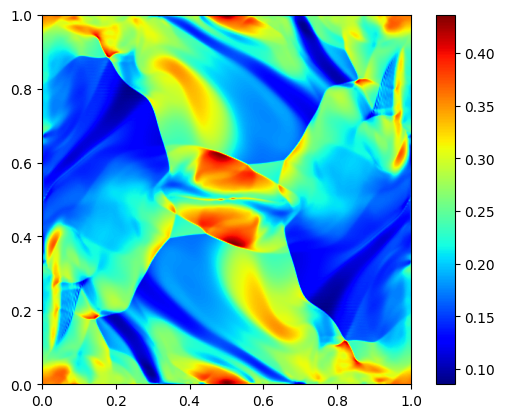

In [12]:
plt.imshow(final_state[0, ...].T, cmap = "jet", origin = "lower", extent=[0, 1, 0, 1])
plt.colorbar()

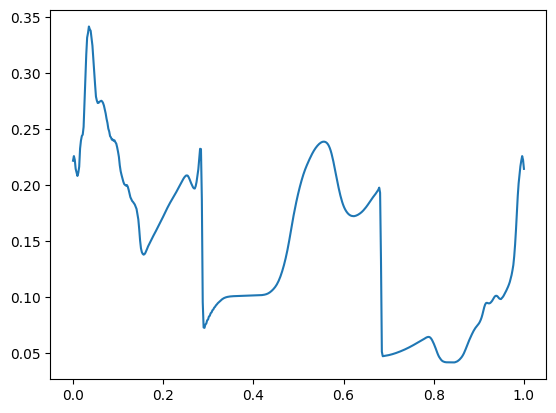

In [13]:
# plot the pressure at y = 0.4277
y = jnp.linspace(0, 1, num_cells)
x = jnp.linspace(0, 1, num_cells)
# find the index closest to 0.4277
y_index = jnp.argmin(jnp.abs(y - 0.3125))

plt.plot(x, final_state[3, :, y_index], label = "Pressure")

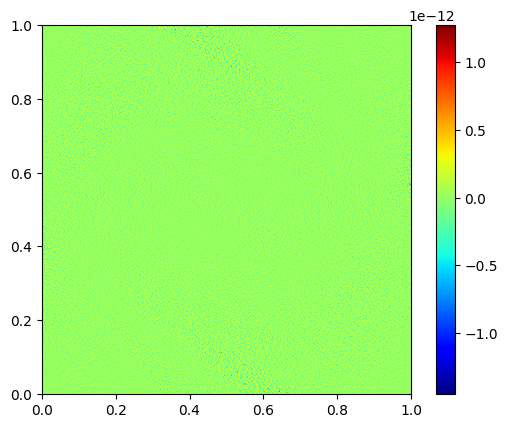

In [14]:
# divergence of the magnetic field
from jf1uids._physics_modules._mhd.mhd_maths import divergence2D


B_x = final_state[4, ...]
B_y = final_state[5, ...]
B_z = final_state[6, ...]

B = jnp.stack([B_x, B_y, B_z], axis=0)

divB = divergence2D(B, dx)

plt.imshow(divB.T, cmap = "jet", origin = "lower", extent=[0, 1, 0, 1])
plt.colorbar()